In [ ]:
!pip install wordcloud
!pip install cufflinks

import json
import gzip
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.8 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
!wget --no-check-certificate https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Pet_Supplies_5.json.gz


--2022-12-10 19:53:14--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Pet_Supplies_5.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 306131006 (292M) [application/x-gzip]
Saving to: ‘Pet_Supplies_5.json.gz’

Pet_Supplies_5.json 100%[===================>] 291.95M  42.4MB/s    in 7.3s    

2022-12-10 19:53:22 (40.2 MB/s) - ‘Pet_Supplies_5.json.gz’ saved [306131006/306131006]



In [ ]:
data = []
with gzip.open('Pet_Supplies_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
df = pd.DataFrame.from_dict(data)

In [ ]:
#df.to_csv('pet_supplies.csv', header=True, index=False)
#data = pd.read_csv('pet_supplies.csv')
#data.head(5)

In [ ]:
# Sentiment does not necessarily reflect the rating, we are making this assumption, we could mention that in presentation as a setback.
# For example rating may be one star but review text may be "too big" and too big might not have a very negative sentiment in general
# Also too big might have rating of 1 for one person while it's a 3 for another person, we're taking it for what it is and not questioning the objectivity
# Difference between guessing Sentiment and predicting Sentiment (differences in approaches lexical rule based approaches vs automatic training based approaches)
# Haven't grouped them by the dates yet
df = df[df['reviewText'].notna()]
df['reviewTime'] = pd.to_datetime(df['reviewTime'], infer_datetime_format=True)  
df.drop(['reviewerName', 'unixReviewTime', 'style', 'image'], inplace = True, axis = 1)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary
0,3.0,2,True,2016-12-02,A2KN4FJVI2TZSF,0972585419,I purchased this cd for my Pocket Parrot. It h...,It's okay
1,3.0,NaN,True,2016-10-17,A3RMA1DD66JDRV,0972585419,"Maybe it's just my Amazon parrot, but she's no...",It might work for a different bird
2,5.0,2,True,2016-09-09,AAANYRIEOIT3R,0972585419,I bought this to help me teach my blue quaker ...,I bought this to help me teach my blue quaker ...
3,3.0,NaN,True,2016-08-31,A3W44VX0LXAOHU,0972585419,Bird showed no interest in it....,Three Stars
4,2.0,NaN,True,2016-08-18,A16ZDBZGKYDRSU,0972585419,Didn't do a thing for my African Grey! He hate...,He hated it and it was very obnoxious


In [ ]:
# Functions
# Compare sentiment scores (for lexical approach)
def compare_sentiments(pos, neg, neu):
    if (pos>neg) and (pos>neu):
        return "Positive"
    elif (neg>pos) and (neg>neu):
        return "Negative"
    else:
        return "Neutral"

# convert rating to sentiments
def convert_sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

# Add sentiments to the data
df["Sentiment"] = df["overall"].apply(convert_sentiments)


In [ ]:
df[df["Sentiment"]=="Negative"]

,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,Sentiment
4,2.0,NaN,True,2016-08-18,A16ZDBZGKYDRSU,0972585419,Didn't do a thing for my African Grey! He hate...,He hated it and it was very obnoxious,Negative
9,1.0,NaN,True,2015-01-13,ALF0MRD3LRTPN,0972585419,I was reLly disappointed the cd has a lot of s...,I was reLly disappointed the cd has a lot of s...,Negative
10,1.0,NaN,True,2014-10-02,A3DQ9Q7AE4JVO8,0972585419,It does not contain many words that we would w...,It does not contain many words that we would w...,Negative
12,1.0,6,False,2013-03-23,A29BY9ABO4FDEZ,0972585419,"If you want your bird to interact with you, th...",Waste of $,Negative
14,1.0,20,False,2008-10-24,A112XLN4J4TYLR,0972585419,This is the biggest waste of money - do not bu...,Waste of Money,Negative
...,...,...,...,...,...,...,...,...,...
2098302,2.0,NaN,True,2018-07-31,A1W6UAIXO8327J,B01HI97HAG,"With two dogs that pull a bit, the plastic buc...",Two Stars,Negative
2098306,2.0,6,True,2018-03-13,A2BOIW285K36FK,B01HI9QDBA,This litter box is difficult to clean because ...,Difficult to clean; I'm constantly wiping up d...,Negative
2098307,1.0,NaN,False,2017-12-11,A8CO0IDUUKV7J,B01HIJGHOS,"So, we got a new puppy. Ranch raised aka has ...",IT STINKS.,Negative
2098308,1.0,NaN,False,2017-12-10,A1JCBBG8KW3PLY,B01HIJGHOS,This product was recommended to replace the S...,Not for on minimum-fur cats!,Negative


In [ ]:
# using the nltk sentiment analyzer in this cell
# A lexical approach using NLTK vader sentiment intensity analyzer instead of machine learning approach that requires training
# It combines a dictionary, which maps lexical features to emotion intensity, and five heuristics, 
# It encodes how contextual elements increment, decrement, or negate the sentiment of text.
# Unlike automatic mahine learning approaches, it doesn't get rid of punctuations and stop words and no tokenization like some of the other machine learning approaches
# Sentiment values are on a continuous scale when compared, while for other machine learning it's categorical
# pros- don't need previously labeled data
# Cons: not as accurate, hard to validate, and a very naive approach, also not specfic to our dataset
# https://medium.com/@piocalderon/vader-sentiment-analysis-explained-f1c4f9101cd9
# Might be interesting to compare the two approaches

#sentiments = SentimentIntensityAnalyzer()
#df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["reviewText"]]
#df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["reviewText"]]
#df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["reviewText"]]
#df["Sentiment_lex_approach"] = df.apply(lambda x: compare_sentiments(x.Positive, x.Negative, x.Neutral), axis=1)
#df.sort_values('overall')

In [ ]:
# first plot is using the lexical approach
#cross_tab_prop = pd.crosstab(index=df['asin'], columns=df['Sentiment_lex_approach'], normalize="index")
#cross_tab_prop.plot(kind = 'bar', stacked = True)

# second plot is just straight from converting the "overall" rating column to sentiments
#cross_tab_prop_rating = pd.crosstab(index=df['asin'], columns=df['Sentiment'], normalize="index")
#cross_tab_prop_rating.plot(kind = 'bar', stacked = True)

In [ ]:
# Onto automatic machine learning methods
# Pros: More accuracy with as you train with bigger data sets, more flexibility
# Cons: Need labeled data to train on
# This means we have to make assuptions about Sentiments based on stars
# I used Negative (1 and 2) Neutral (3) and Positive(4 and 5)
# A few possible approaches Using Bayes Multinomial
# Use Word2Vec
# Use Word Embeddings

In [ ]:
#Split into train and test...
#Size a bit small use another dataset?
train_df, test_df = train_test_split(df, test_size = 0.5, random_state = 42, shuffle = True)
test_df, final_df = train_test_split(test_df, test_size = 0.5, random_state = 42, shuffle = True)
train_df_neutral = train_df[train_df['Sentiment']=="Neutral"].sample(80000)
train_df_negative = train_df[train_df['Sentiment']=="Negative"].sample(80000)
train_df_positive = train_df[train_df['Sentiment']=="Positive"].sample(80000)
train_df = pd.concat([train_df_neutral, train_df_negative, train_df_positive])
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(100000)
final_df = final_df.sample(100000)
X_train = train_df['reviewText']
Y_train = train_df['Sentiment']
X_test = test_df['reviewText']
Y_test = test_df['Sentiment']
X_final = final_df['reviewText']
Y_final = final_df['Sentiment']
print(len(X_train), len(X_test), len(X_final))

240000 100000 100000


In [ ]:
#Use bag of words to turn the reviews into numerical vectors
#Pre-processing by 1. tokenization (split sentence to words) and 2. Stopwords (get rid of common words with no effect on sentiment)
from sklearn.feature_extraction.text import CountVectorizer 
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train) 

from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(use_idf=False)
X_train_stop = transformer.fit_transform(X_train_counts)
X_train_stop.shape

(240000, 61558)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), 
                             ("tfidf", TfidfTransformer()),
                             ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, Y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', MultinomialNB())])

In [ ]:
#@title Default title text
# Naive Bayes is a simplified version of Bayes Theorem, where all features are assumed conditioned independent to each other 
import numpy as np
predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == Y_test)

0.71046

In [ ]:
predictedMultiNB_final = clf_multiNB_pipe.predict(X_final)
np.mean(predictedMultiNB_final == Y_final)

0.71348

In [ ]:
final_df['predicted_Sentiment'] = predictedMultiNB_final
final_df

,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,Sentiment,predicted_Sentiment
2084022,5.0,NaN,True,2017-10-06,A35UCCOJFAAVUL,B017IOTU88,My cats love this a lot more than I thought th...,My cats love this a lot more than I thought th...,Positive,Positive
1066422,5.0,NaN,True,2016-03-05,A3HEJHU3W3YISP,B004UTDHP2,I have a yorkie and was having trouble keeping...,I have a yorkie and was having trouble keeping...,Positive,Positive
453829,5.0,NaN,True,2016-12-16,A1KFY82KQI0OWN,B000N32NGI,Great ball. Very durable. To make my pup go nu...,Awesome choice,Positive,Neutral
865348,2.0,NaN,False,2015-08-31,A2IL2MT944PWW0,B001U8T1D8,This bowl is not ant-proof...at least not if y...,Maybe other species are more stupid and will b...,Negative,Negative
262579,1.0,NaN,False,2012-07-31,A40TYRG1G71V6,B0006G5LE8,"PROPYLENE GLYCOL\nis a colorless, viscous, hyg...",Hartz ear cleaner,Negative,Negative
...,...,...,...,...,...,...,...,...,...,...
1113447,3.0,NaN,True,2014-05-24,A2XL1SZOPG6Y06,B005AXN2BG,Bought for the new puppy. She chewed it in ha...,Do not buy if your dog is a chewer.,Neutral,Negative
1706682,5.0,NaN,True,2016-03-19,A3W1Q9PXU8QGUQ,B00UZXPM00,I love this thing! Very well made and comforta...,Best hands free leash,Positive,Positive
829296,5.0,2,True,2017-02-03,AGSRRNJQW4S61,B001KN3Q0C,"A favorite rope toy, but use with caution!\nOu...",A favorite rope toy,Positive,Positive
270930,5.0,NaN,True,2013-03-12,A1J25FRYTCURLT,B0006L12V4,"My mice are in my room, and now I can finally ...",Perfect!,Positive,Positive


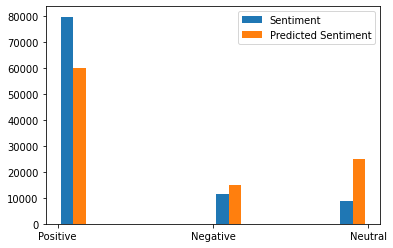

In [ ]:
plt.hist([final_df['Sentiment'], final_df['predicted_Sentiment']])
plt.legend(['Sentiment', 'Predicted Sentiment'])

(array([59873.,     0.,     0.,     0.,     0., 25014.,     0.,     0.,
            0., 15113.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

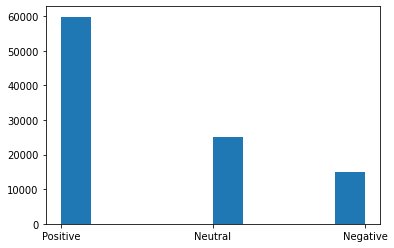

In [ ]:
plt.hist(final_df['predicted_Sentiment'])

In [ ]:
true_positive = final_df[(final_df['Sentiment']=='Positive') & (final_df['predicted_Sentiment']=='Positive')].shape[0]
positive = final_df[final_df['Sentiment']=='Positive'].shape[0]
positive_accuracy = true_positive/positive*100
positive_accuracy

72.9149173486396

In [ ]:
true_neutral = final_df[(final_df['Sentiment']=='Neutral') & (final_df['predicted_Sentiment']=='Neutral')].shape[0]
neutral = final_df[final_df['Sentiment']=='Neutral'].shape[0]
neutral_accuracy = true_neutral/neutral*100
neutral_accuracy

63.5598108201638

In [ ]:
true_negative = final_df[(final_df['Sentiment']=='Negative') & (final_df['predicted_Sentiment']=='Negative')].shape[0]
negative = final_df[final_df['Sentiment']=='Negative'].shape[0]
negative_accuracy = true_negative/negative*100
negative_accuracy

66.36332119951464

In [ ]:
one_hot = pd.get_dummies(final_df['Sentiment'])
final_df = final_df.join(one_hot)

In [ ]:
final_df.groupby([df['reviewTime'].dt.to_period('Q'), df['asin']]).sum()[['Positive', 'Negative', 'Neutral']]

Positive  Negative  Neutral
reviewTime asin                                   
2010Q1     B00006H36X         0         1        0
           B000084E6V         1         0        0
           B000084EJO         1         0        0
           B00008DFGY         0         1        0
           B0000AH9UH         1         0        0
...                         ...       ...      ...
2018Q3     B01HEFT7CU         1         0        0
           B01HEFT7L6         1         0        0
           B01HGQP6KO         1         0        0
           B01HHUADP2         1         0        0
           B01HIQ9NGU         1         0        0

[67890 rows x 3 columns]

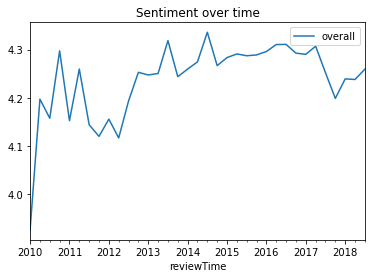

In [ ]:
one_hot = pd.get_dummies(final_df['Sentiment'])
final_df = final_df[final_df['reviewTime'] > '2008-01-01']
df1 = final_df.groupby([df['reviewTime'].dt.to_period('Q')]).mean()[['overall']]
df1.plot(title = 'Sentiment over time')